<a href="https://colab.research.google.com/github/TranDucLongAIDHSPKTHY/Recommendation-system-for-Movies/blob/main/Recommendation_systems_for_Movies_using_Deep_Learning_(CF_ITEM_BASED).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import thư viện

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch.nn.functional as F

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Đọc file csv

In [ ]:
rating = pd.read_csv('/content/drive/My Drive/Project4_Trần Đức Long_124211/movie-25M/ratings.csv')
movie = pd.read_csv('/content/drive/My Drive/Project4_Trần Đức Long_124211/movie-25M/movies.csv')

In [ ]:
rating.head(3)

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828


In [ ]:
movie.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


#Giải thích dữ liệu & Tiền xử lý dữ liệu

In [ ]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB


In [ ]:
# Kiểm tra các giá trị thiếu
print(rating.isnull().sum())

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


In [ ]:
# Kiểm tra các giá trị trùng lặp
print(rating.duplicated().sum())

0


In [ ]:
movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [ ]:
# Kiểm tra các giá trị thiếu
print(movie.isnull().sum())

movieId    0
title      0
genres     0
dtype: int64


In [ ]:
# Kiểm tra các giá trị trùng lặp
print(movie.duplicated().sum())

0


In [ ]:
ratings = rating.head(100000)#25000094

In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100000 non-null  int64  
 1   movieId    100000 non-null  int64  
 2   rating     100000 non-null  float64
 3   timestamp  100000 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [ ]:
movies = movie.head(50000)

In [ ]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  50000 non-null  int64 
 1   title    50000 non-null  object
 2   genres   50000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [ ]:
merged = pd.merge(ratings, movies, on='movieId')
data = merged[['userId', 'movieId', 'rating','']]

In [ ]:
data.head()

,userId,movieId,rating
0,1,296,5.0
1,1,306,3.5
2,1,307,5.0
3,1,665,5.0
4,1,899,3.5


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99604 entries, 0 to 99603
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   userId   99604 non-null  int64  
 1   movieId  99604 non-null  int64  
 2   rating   99604 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB


In [ ]:
# Đánh chỉ số cho user_id và movie_id
user_ids = data['userId'].unique().tolist()
movie_ids = data['movieId'].unique().tolist()
user_id_to_index = {x: i for i, x in enumerate(user_ids)}
movie_id_to_index = {x: i for i, x in enumerate(movie_ids)}


In [ ]:
# Thay thế user_id và movie_id bằng các chỉ số
data['user'] = data['userId'].map(user_id_to_index)
data['movie'] = data['movieId'].map(movie_id_to_index)

<ipython-input-22-ee023a0a1df5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['user'] = data['userId'].map(user_id_to_index)
<ipython-input-22-ee023a0a1df5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['movie'] = data['movieId'].map(movie_id_to_index)


# Trực quan hóa dữ liệu

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

<ipython-input-24-33c6aa5e6fca>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='rating', palette='viridis')


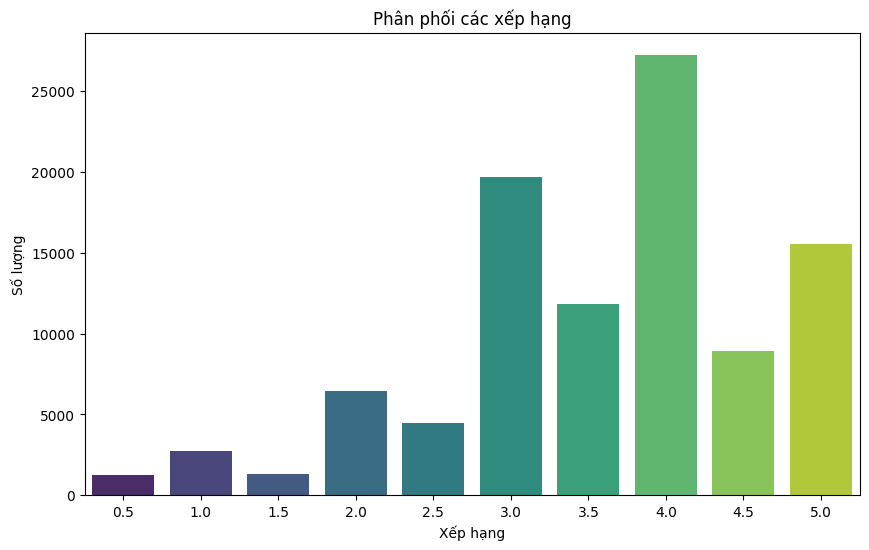

In [ ]:
#Biểu đồ phân phối xếp hạng của các bộ phim
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='rating', palette='viridis')
plt.title('Phân phối các xếp hạng')
plt.xlabel('Xếp hạng')
plt.ylabel('Số lượng')
plt.show()

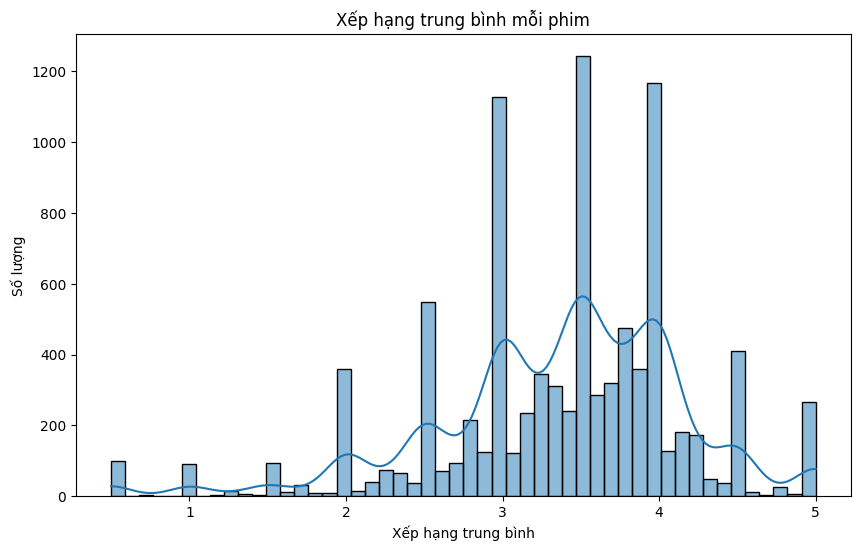

In [ ]:
# Tính trung bình xếp hạng cho mỗi phim
average_rating_per_movie = data.groupby('movieId')['rating'].mean()
plt.figure(figsize=(10, 6))
sns.histplot(average_rating_per_movie, bins=50, kde=True)
plt.title('Xếp hạng trung bình mỗi phim')
plt.xlabel('Xếp hạng trung bình')
plt.ylabel('Số lượng')
plt.show()

# Train & Test

In [ ]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
# Đếm số lượng mẫu trong mỗi tập
train_count = len(train)
test_count = len(test)

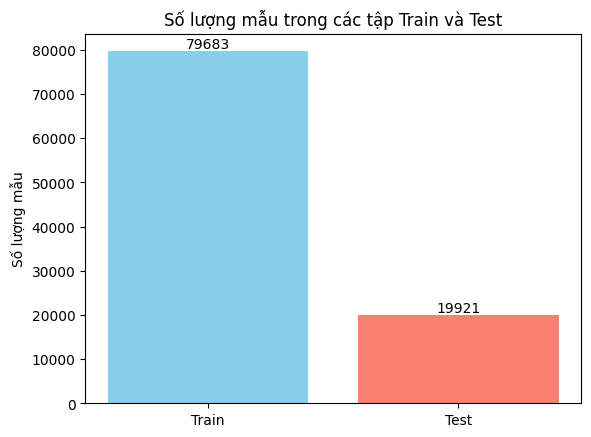

In [ ]:
# Vẽ biểu đồ
labels = ['Train', 'Test']
counts = [train_count, test_count]

plt.bar(labels, counts, color=['skyblue', 'salmon'])

# Hiển thị số lượng mẫu trên đỉnh mỗi cột
for i, count in enumerate(counts):
    plt.text(i, count + 100, str(count), ha='center', va='bottom')

plt.ylabel('Số lượng mẫu')
plt.title('Số lượng mẫu trong các tập Train và Test')
plt.show()

# Build model Autuencoder & NCF_MLP

In [ ]:
# Định nghĩa dataset
class RatingsDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        user = self.data.iloc[idx]['user']
        movie = self.data.iloc[idx]['movie']
        rating = self.data.iloc[idx]['rating']
        return torch.tensor(user), torch.tensor(movie), torch.tensor(rating, dtype=torch.float32)


In [ ]:
# Tạo dataset cho train và test
train_dataset = RatingsDataset(train)
test_dataset = RatingsDataset(test)

In [ ]:
# Tạo DataLoader để lấy các batch dữ liệu
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True) #trộn ngẫu nhiên dữ liệu.
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False) #giữ nguyên thứ tự dữ liệu.

In [ ]:
# Khai báo số lượng người dùng, phim
num_users = len(user_ids)
num_movies = len(movie_ids)
embedding_size = 50

In [ ]:
# Định nghĩa mô hình Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, num_users, num_movies, embedding_size=50):
        super(Autoencoder, self).__init__()

        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.movie_embedding = nn.Embedding(num_movies, embedding_size)

        self.encoder_fc1 = nn.Linear(embedding_size * 2, 256)
        self.encoder_fc2 = nn.Linear(256, 128)
        self.encoder_fc3 = nn.Linear(128, 64)

        self.decoder_fc1 = nn.Linear(64, 128)
        self.decoder_fc2 = nn.Linear(128, 256)
        self.decoder_fc3 = nn.Linear(256, embedding_size * 2)
        self.output_layer = nn.Linear(embedding_size * 2, 1)

    def forward(self, user, movie):
        user_embedded = self.user_embedding(user)
        movie_embedded = self.movie_embedding(movie)
        x = torch.cat([user_embedded, movie_embedded], dim=1)

        x = torch.relu(self.encoder_fc1(x))
        x = torch.relu(self.encoder_fc2(x))
        x = torch.relu(self.encoder_fc3(x))

        x = torch.relu(self.decoder_fc1(x))
        x = torch.relu(self.decoder_fc2(x))
        x = self.decoder_fc3(x)
        x = self.output_layer(x)
        return x

In [ ]:
# Định nghĩa mô hình MLP trong NCF
class NCF_MLP(nn.Module):
    def __init__(self, num_users, num_movies, embedding_size=50):
        super(NCF_MLP, self).__init__() #Gọi hàm khởi tạo của lớp cha
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.movie_embedding = nn.Embedding(num_movies, embedding_size)

        hidden_layers = [256, 128, 64]
        input_size = embedding_size * 2
        layers = [] #chứa các lớp FC nối tiếp nhau
        for hidden_layer_size in hidden_layers:
            layers.append(nn.Linear(input_size, hidden_layer_size))
            layers.append(nn.ReLU())
            input_size = hidden_layer_size #update

        self.mlp_layers = nn.Sequential(*layers)
        self.output_layer = nn.Linear(hidden_layers[-1], 1)

    def forward(self, user, movie):
        user_embedded = self.user_embedding(user)
        movie_embedded = self.movie_embedding(movie)
        x = torch.cat([user_embedded, movie_embedded], dim=1)
        x = self.mlp_layers(x)
        x = self.output_layer(x)
        return x

In [ ]:
autoencoder = Autoencoder(num_users, num_movies, embedding_size)
ncf_model = NCF_MLP(num_users, num_movies, embedding_size)

In [ ]:
'''
# Hàm mục tiêu: sử dụng MSE
criterion = nn.MSELoss()
autoencoder_optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
ncf_optimizer = optim.Adam(ncf_model.parameters(), lr=0.001)
'''

'\n# Hàm mục tiêu: sử dụng MSE\ncriterion = nn.MSELoss()\nautoencoder_optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)\nncf_optimizer = optim.Adam(ncf_model.parameters(), lr=0.001)\n'

In [ ]:
'''
# Huấn luyện mô hình Autoencoder
def train_autoencoder():
    autoencoder.train()
    train_loss = 0


    for user, movie, rating in train_loader:
        user = user.long()
        movie = movie.long()
        rating = rating.float().view(-1) #định dạng lại kích thước view(-1) 1 mảng 1 chiều

        autoencoder_optimizer.zero_grad()
        output = autoencoder(user, movie)
        loss = criterion(output.view(-1), rating)
        loss.backward()
        autoencoder_optimizer.step()

        train_loss += loss.item()

    return train_loss / len(train_loader)          # Trả về tổn thất trung bình trên toàn bộ tập huấn luyện
'''

'\n# Huấn luyện mô hình Autoencoder\ndef train_autoencoder():\n    autoencoder.train()\n    train_loss = 0\n\n\n    for user, movie, rating in train_loader:\n        user = user.long()\n        movie = movie.long()\n        rating = rating.float().view(-1) #định dạng lại kích thước view(-1) 1 mảng 1 chiều\n\n        autoencoder_optimizer.zero_grad()\n        output = autoencoder(user, movie)\n        loss = criterion(output.view(-1), rating)\n        loss.backward()\n        autoencoder_optimizer.step()\n\n        train_loss += loss.item()\n\n    return train_loss / len(train_loader)          # Trả về tổn thất trung bình trên toàn bộ tập huấn luyện\n'

In [ ]:
'''
# Hàm huấn luyện cho mô hình MLP
def train_ncf():
    ncf_model.train()
    train_loss = 0
    for user, movie, rating in train_loader:
        user = user.long()
        movie = movie.long()
        rating = rating.float().view(-1)
        ncf_optimizer.zero_grad()
        output = ncf_model(user, movie)
        loss = criterion(output.view(-1), rating)
        loss.backward()
        ncf_optimizer.step()
        train_loss += loss.item()
    return train_loss / len(train_loader)
'''

'\n# Hàm huấn luyện cho mô hình MLP\ndef train_ncf():\n    ncf_model.train()\n    train_loss = 0\n    for user, movie, rating in train_loader:\n        user = user.long()\n        movie = movie.long()\n        rating = rating.float().view(-1)\n        ncf_optimizer.zero_grad()\n        output = ncf_model(user, movie)\n        loss = criterion(output.view(-1), rating)\n        loss.backward()\n        ncf_optimizer.step()\n        train_loss += loss.item()\n    return train_loss / len(train_loader)\n'

In [ ]:
'''
num_epochs = 10

for epoch in range(num_epochs):
    autoencoder_loss = train_autoencoder()
    ncf_loss = train_ncf()
    print(f'Epoch {epoch+1}/{num_epochs}, Autoencoder Loss: {autoencoder_loss:.4f}, NCF Loss: {ncf_loss:.4f}')
'''

"\nnum_epochs = 10\n\nfor epoch in range(num_epochs):\n    autoencoder_loss = train_autoencoder()\n    ncf_loss = train_ncf()\n    print(f'Epoch {epoch+1}/{num_epochs}, Autoencoder Loss: {autoencoder_loss:.4f}, NCF Loss: {ncf_loss:.4f}')\n"

- Epoch 1/10, Autoencoder Loss: 1.3602, NCF Loss: 1.3493
- Epoch 2/10, Autoencoder Loss: 0.8710, NCF Loss: 0.8617
- Epoch 3/10, Autoencoder Loss: 0.8066, NCF Loss: 0.8012
- Epoch 4/10, Autoencoder Loss: 0.7680, NCF Loss: 0.7587
- Epoch 5/10, Autoencoder Loss: 0.7343, NCF Loss: 0.7264
- Epoch 6/10, Autoencoder Loss: 0.7073, NCF Loss: 0.6993
- Epoch 7/10, Autoencoder Loss: 0.6809, NCF Loss: 0.6773
- Epoch 8/10, Autoencoder Loss: 0.6572, NCF Loss: 0.6568
- Epoch 9/10, Autoencoder Loss: 0.6356, NCF Loss: 0.6381
- Epoch 10/10, Autoencoder Loss: 0.6104, NCF Loss: 0.6209

In [ ]:
'''
# Lưu mô hình Autoencoder
torch.save(autoencoder.state_dict(), '/content/drive/My Drive/Project4_Trần Đức Long_124211/autoencoder_model_real.pth')

# Lưu mô hình NCF_MLP
torch.save(ncf_model.state_dict(), '/content/drive/My Drive/Project4_Trần Đức Long_124211/ncf_mlp_model_real.pth')
'''


"\n# Lưu mô hình Autoencoder\ntorch.save(autoencoder.state_dict(), '/content/drive/My Drive/Project4_Trần Đức Long_124211/autoencoder_model_real.pth')\n\n# Lưu mô hình NCF_MLP\ntorch.save(ncf_model.state_dict(), '/content/drive/My Drive/Project4_Trần Đức Long_124211/ncf_mlp_model_real.pth')\n"

In [ ]:

#Tải mô hình đã lưu
autoencoder.load_state_dict(torch.load('/content/drive/My Drive/Project4_Trần Đức Long_124211/autoencoder_model_real.pth'))
ncf_model.load_state_dict(torch.load('/content/drive/My Drive/Project4_Trần Đức Long_124211/ncf_mlp_model_real.pth'))


<ipython-input-41-9edb0c8379b6>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load('/content/drive/My Drive/Project4_Trần Đức Long_12421

<All keys matched successfully>

In [ ]:
print(autoencoder)

Autoencoder(
  (user_embedding): Embedding(757, 50)
  (movie_embedding): Embedding(9548, 50)
  (encoder_fc1): Linear(in_features=100, out_features=256, bias=True)
  (encoder_fc2): Linear(in_features=256, out_features=128, bias=True)
  (encoder_fc3): Linear(in_features=128, out_features=64, bias=True)
  (decoder_fc1): Linear(in_features=64, out_features=128, bias=True)
  (decoder_fc2): Linear(in_features=128, out_features=256, bias=True)
  (decoder_fc3): Linear(in_features=256, out_features=100, bias=True)
  (output_layer): Linear(in_features=100, out_features=1, bias=True)
)


In [ ]:
print(ncf_model)

NCF_MLP(
  (user_embedding): Embedding(757, 50)
  (movie_embedding): Embedding(9548, 50)
  (mlp_layers): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
  )
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)


# Metrics RMSE & MAE

In [ ]:
def evaluate_model(model, dataloader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for user, movie, rating in dataloader:
            user = user.long()
            movie = movie.long()
            output = model(user, movie)
            predictions.extend(output.numpy().flatten())
            actuals.extend(rating.numpy().flatten())

    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)

    return rmse, mae

In [ ]:
#Đánh giá mô hình
autoencoder_rmse, autoencoder_mae = evaluate_model(autoencoder, test_loader)
ncf_rmse, ncf_mae = evaluate_model(ncf_model, test_loader)

print(f'Autoencoder RMSE: {autoencoder_rmse:.4f}, MAE: {autoencoder_mae:.4f}')
print(f'NCF RMSE: {ncf_rmse:.4f}, MAE: {ncf_mae:.4f}')

Autoencoder RMSE: 0.9219, MAE: 0.7042
NCF RMSE: 0.8978, MAE: 0.6973


# Cosine similarity

In [ ]:
'''
# Tính cosine similarity cho movie
def cosine_similarity_matrix(embeddings):
    normalized_embeddings = F.normalize(embeddings, p=2, dim=1)
    return torch.mm(normalized_embeddings, normalized_embeddings.t())
'''

'\n# Tính cosine similarity cho movie\ndef cosine_similarity_matrix(embeddings):\n    normalized_embeddings = F.normalize(embeddings, p=2, dim=1)\n    return torch.mm(normalized_embeddings, normalized_embeddings.t())\n'

In [ ]:
'''
# Hàm tính similarity cho tất cả các movie
def movie_similarity(ncf_model, num_movies):
    with torch.no_grad():
        movie_embeddings = ncf_model.movie_embedding.weight
        similarity_matrix = cosine_similarity_matrix(movie_embeddings)
    return similarity_matrix.numpy()
'''

'\n# Hàm tính similarity cho tất cả các movie\ndef movie_similarity(ncf_model, num_movies):\n    with torch.no_grad():\n        movie_embeddings = ncf_model.movie_embedding.weight\n        similarity_matrix = cosine_similarity_matrix(movie_embeddings)\n    return similarity_matrix.numpy()\n'

In [ ]:
'''
# Tính similarity cho các movie
movie_similarity = movie_similarity(ncf_model, num_movies)
'''

'\n# Tính similarity cho các movie\nmovie_similarity = movie_similarity(ncf_model, num_movies)\n'

In [ ]:
'''
import pickle

# Định nghĩa đường dẫn file
file_path = '/content/drive/My Drive/Project4_Trần Đức Long_124211/movie_similarity_real.pkl'

# Lưu ma trận similarity vào file .pkl bằng pickle
with open(file_path, 'wb') as f:
    pickle.dump(movie_similarity, f)

print("Đã lưu ma trận similarity vào file .pkl.")
'''

'\nimport pickle\n\n# Định nghĩa đường dẫn file\nfile_path = \'/content/drive/My Drive/Project4_Trần Đức Long_124211/movie_similarity_real.pkl\'\n\n# Lưu ma trận similarity vào file .pkl bằng pickle\nwith open(file_path, \'wb\') as f:\n    pickle.dump(movie_similarity, f)\n\nprint("Đã lưu ma trận similarity vào file .pkl.")\n'

In [ ]:

# Tải ma trận similarity từ tệp đã lưu
file_path_similarity = '/content/drive/My Drive/Project4_Trần Đức Long_124211/movie_similarity_real.pkl'
movie_similarity = pd.read_pickle(file_path_similarity)


# Hàm gợi ý phim

In [ ]:
list_title = dict(zip(movie['movieId'], movie['title']))

In [ ]:
# Hàm gợi ý phim
def get_movie_recommendations(movie_id, similarity_matrix, movie_ids, list_title, top_n=10):
    movie_idx = movie_id_to_index[movie_id]
    similar_indices = np.argsort(similarity_matrix[movie_idx])[-top_n-1:-1][::-1]
    recommended_movies = [list_title[movie_ids[i]] for i in similar_indices]
    return recommended_movies

In [ ]:
id_movie = 99
recommended_movies = get_movie_recommendations( id_movie, movie_similarity, movie_ids, list_title)
print("Recommended Movies:")
for index, movie in enumerate(recommended_movies, start=1):
    print(f"{index}. {movie}")

Recommended Movies:
1. Topsy-Turvy (1999)
2. Crossroads (2002)
3. Tomorrow Was the War (1987)
4. House Party (1990)
5. Help! (1965)
6. Whiskey Tango Foxtrot (2016)
7. Big Short, The (2015)
8. Peter Pan (2003)
9. I Was a Male War Bride (1949)
10. Psychometry (2013)


In [ ]:
'''
file_path = '/content/drive/My Drive/Project4_Trần Đức Long_124211/data.pkl'

# Lưu DataFrame vào file .pkl
data.to_pickle(file_path)
'''


"\nfile_path = '/content/drive/My Drive/Project4_Trần Đức Long_124211/data.pkl'\n\n# Lưu DataFrame vào file .pkl\ndata.to_pickle(file_path)\n"

Dataset: https://www.kaggle.com/datasets/garymk/movielens-25m-dataset/data